## Examine data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
import seaborn as sns

In [28]:
data_dir = './data'

In [29]:
df_train = pd.read_csv(data_dir + '/train.csv')
df_test = pd.read_csv(data_dir + '/test.csv')
df_labels = pd.read_csv(data_dir + '/labels.csv')

In [28]:
print(len(df_train[df_train['Risk_Flag'] == 1]) / len(df_train[df_train['Risk_Flag'] == 0]))

0.1402508551881414


In [37]:
profession_order = None 
city_order = None
state_order = None
married_order = None
house_order = None
car_owned_order = None

for column in df_train.columns:
    if column not in ['Id','Risk_Flag', 'Income']:
        df_risk_by_attrib = df_train[[column,'Risk_Flag']].groupby([column]).mean()
        
        if column in ['Profession', 'CITY', 'STATE', 'Married/Single', 'House_Ownership', 'Car_Ownership']:
            df_risk_by_attrib = df_risk_by_attrib.sort_values('Risk_Flag')
            
            if column == 'Profession':
                profession_order = np.array(df_risk_by_attrib.index)
            
            if column == 'CITY':
                city_order = np.array(df_risk_by_attrib.index)
                
            if column == 'STATE':
                state_order = np.array(df_risk_by_attrib.index)
                
            if column == 'Married/Single':
                married_order = np.array(df_risk_by_attrib.index)
            
            if column == 'House_Ownership':
                house_order = np.array(df_risk_by_attrib.index)
                
            if column == 'Car_Ownership':
                car_owned_order = np.array(df_risk_by_attrib.index)
        
        # if column not in ['Married/Single', 'House_Ownership', 'Car_Ownership']:
        #     fig,ax = plt.subplots()
        #     
        #     ax.plot(df_risk_by_attrib.index, df_risk_by_attrib['Risk_Flag'])
        #         
        #     plt.xticks(rotation='vertical')
        #     plt.ylabel('Chance of risk')
        #     plt.xlabel(column)

AAAA


In [35]:
married_order

In [39]:
df_train['Profession_labeled'] = df_train['Profession'].apply(lambda x: np.where(profession_order == x)[0][0])
df_train['City_labeled'] = df_train['CITY'].apply(lambda x: np.where(city_order == x)[0][0])
df_train['State_labeled'] = df_train['STATE'].apply(lambda x: np.where(state_order == x)[0][0])
df_train['Married_labeled'] = df_train['Married/Single'].apply(lambda x: np.where(married_order == x)[0][0])
df_train['House_labeled'] = df_train['House_Ownership'].apply(lambda x: np.where(house_order == x)[0][0])
df_train['Car_labeled'] = df_train['Car_Ownership'].apply(lambda x: np.where(car_owned_order == x)[0][0])

df_train

            Id   Income  Age  Experience Married/Single House_Ownership  \
0            1  1303834   23           3         single          rented   
1            2  7574516   40          10         single          rented   
2            3  3991815   66           4        married          rented   
3            4  6256451   41           2         single          rented   
4            5  5768871   47          11         single          rented   
...        ...      ...  ...         ...            ...             ...   
251995  251996  8154883   43          13         single          rented   
251996  251997  2843572   26          10         single          rented   
251997  251998  4522448   46           7         single          rented   
251998  251999  6507128   45           0         single          rented   
251999  252000  9070230   70          17         single          rented   

       Car_Ownership           Profession                 CITY  \
0                 no  Mechanical_

KeyError: ('Id', 'Income', 'Age', 'Experience', 'Married_labeled', 'House_labeled', 'Car_labeled', 'Profession', 'City_labeled', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag')

In [40]:
with open(data_dir + '/train_encoded.csv', 'w') as f:
    df_train[['Id', 'Income', 'Age', 'Experience', 'Married_labeled', 'House_labeled', 'Car_labeled', 'Profession', 'City_labeled', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']].to_csv(f)

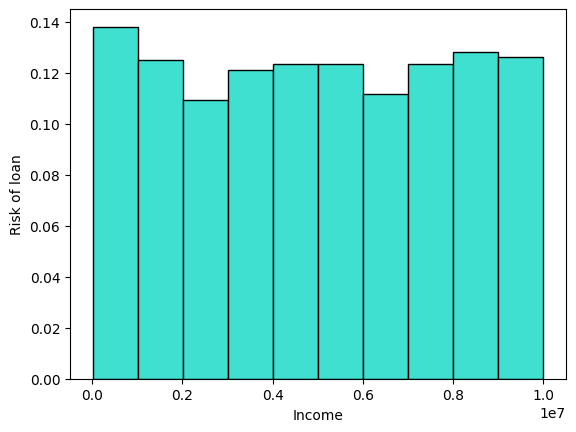

In [84]:
income = df_train['Income'].to_numpy()
risk = df_train['Risk_Flag'].to_numpy()
bins = np.linspace(np.min(income), np.max(income) + 1e-12, 11)
c = np.digitize(income, bins)

plt.bar(bins[:-1], [np.mean(risk[c == i]) for i in range(1, len(bins))], width=bins[1]-bins[0], align='edge', fc='turquoise',ec='black')

#plt.hist(df_train['Income'], df_train['Risk_Flag'])
plt.xlabel('Income')
plt.ylabel('Risk of loan')
plt.show()
# df_train[['Income', 'Risk_Flag']]

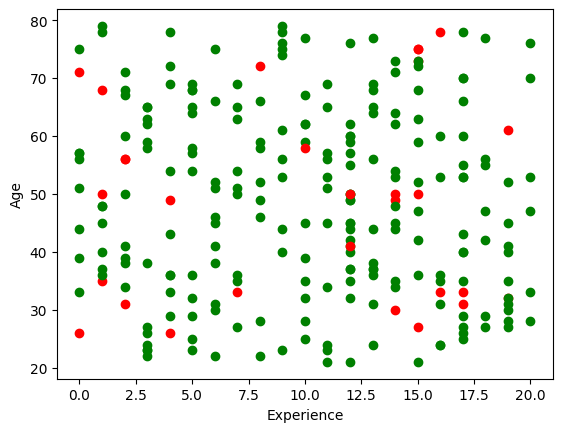

In [100]:
age_and_income = df_train[['Experience','Age','Risk_Flag']].to_numpy()

for client in age_and_income[::1000]:
    # print(client)
    if client[2] == 1:
        plt.plot(client[0], client[1], 'ro')
    else:
        plt.plot(client[0], client[1], 'go')
        
plt.xlabel('Experience')
plt.ylabel('Age')
plt.show()

In [30]:
for attrib in ['Car_Ownership','Married/Single', 'House_Ownership']:
    df_risk_by_attrib = df_train[[attrib,'Risk_Flag']].groupby([attrib]).mean()
    #sns.countplot(x=attrib, hue='Risk_Flag', data=df_train)
    plt.show()
    print(df_risk_by_attrib)

               Risk_Flag
Car_Ownership           
no              0.128188
yes             0.110987
                Risk_Flag
Married/Single           
married          0.102456
single           0.125336
                 Risk_Flag
House_Ownership           
norent_noown      0.099527
owned             0.089797
rented            0.125577


## Training

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_train.drop('Risk_Flag',axis=1), df_train['Risk_Flag'], test_size=0.2,random_state=109)

print(x_train.shape)
print(x_test.shape)

(201600, 12)
(50400, 12)


In [6]:
# Transforming textual attributes to numerical with LabelEncoder
for i, dtype in enumerate(x_train.dtypes):
    if dtype == 'object':
        le = LabelEncoder()
        x_train.iloc[:,i] = le.fit_transform(x_train.iloc[:,i])

In [7]:
x_train

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
190990,190991,394382,64,6,1,2,1,38,35,19,6,13
193343,193344,1737928,28,8,1,2,0,10,285,23,8,10
122760,122761,499939,25,17,0,2,1,8,34,25,9,14
191065,191066,4806237,79,10,0,2,0,48,10,26,4,11
44890,44891,61219,24,7,1,2,0,45,22,2,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...
16368,16369,2603179,39,20,1,2,1,39,275,2,13,11
213133,213134,7458144,26,13,1,2,1,47,27,25,7,11
138997,138998,4278856,59,12,1,2,0,20,303,11,4,11
19701,19702,1874022,44,15,1,2,0,33,291,22,7,14


In [ ]:
clf = svm.SVC(kernel='linear', verbose=True) # Linear Kernel

clf.fit(x_train, y_train)

[LibSVM]............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................